In [ ]:
!pip install matplotlib seaborn numpy scipy nltk wordcloud pandas scikit-learn sentence-transformers openai tqdm

In [26]:
import json
import datetime
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from openai import OpenAI
from tqdm import tqdm
import json

nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nbrandizzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/nbrandizzi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

You can download the projects from :
https://data.europa.eu/data/datasets/cordis-eu-research-projects-under-horizon-europe-2021-2027?locale=en


In [27]:
horizon_projects_file = "/Users/nbrandizzi/repos/kellar/horizon_stats/project.json"
ai_words_file = "/Users/nbrandizzi/repos/kellar/horizon_stats/ai_words.txt"

Open the files

In [28]:
with open(horizon_projects_file) as f:
    horizon_projects = json.load(f)

with open(ai_words_file) as f:
    ai_buzz_words = f.read().splitlines()

# Lowercase all the words
ai_buzz_words = [word.lower() for word in ai_buzz_words if word]

print the data len

In [29]:
print(f"There are {len(horizon_projects)} projects in the file.")

There are 13674 projects in the file.


Get all the projects that have an ai buzz word in the objective or title. 
Also keep track of which words are most common

In [30]:
ai_projects = []
words_present = {}
# for every project in the file check if it has any of the ai words
for project in horizon_projects:
    objective = project["objective"].lower()
    title = project["title"].lower()
    for word in ai_buzz_words:
        if len(word.split(" ")) > 1:
            ai_in_objective = word in objective
            ai_in_title = word in title
        else:
            ai_in_objective = any([word == ob for ob in objective.split(" ")])
            ai_in_title = any([word == ob for ob in title.split(" ")])
        if ai_in_objective or ai_in_title:
            ai_projects.append(project)
            if word not in words_present:
                words_present[word] = 0
            words_present[word] += 1

            break

print the data len

In [31]:
print(f"There are {len(ai_projects)} projects with AI in the file.")

print("The most present words are:")
for word in sorted(words_present, key=words_present.get, reverse=True):
    print(f"{word}: {words_present[word]}")

There are 2065 projects with AI in the file.
The most present words are:
machine learning: 726
artificial intelligence : 373
ai: 309
data analysis: 118
neural network: 118
deep learning: 86
robotics: 84
big data: 72
robot: 27
natural language processing: 25
computer vision: 23
reinforcement learning: 18
data governance: 16
pattern recognition: 6
intelligent control: 6
object recognition: 6
autonomous car: 5
computational linguistics: 5
supercomputer: 5
image recognition: 5
expert system: 4
supervised learning: 4
autonomous robots: 3
speech recognition: 3
predictive modeling: 2
swarm intelligence: 2
emotion recognition: 2
decision theory: 1
evolutionary algorithms: 1
nlp: 1
bayesian network: 1
automated reasoning: 1
machine perception: 1
genetic algorithms: 1
probabilistic reasoning: 1
intelligent agent: 1
llms: 1
hidden markov model: 1
markov decision process: 1


Let's estimate some stats
1. Start date of the projects
2. End date of the projects
3. Average duration of the projects
4. Number of projects per year
5. Min, max and average budget
6. Most common topics

The average duration of the projects is 41 months with a standard deviation of 14.0 months
The minimum duration is 6 months and the maximum is 85 months


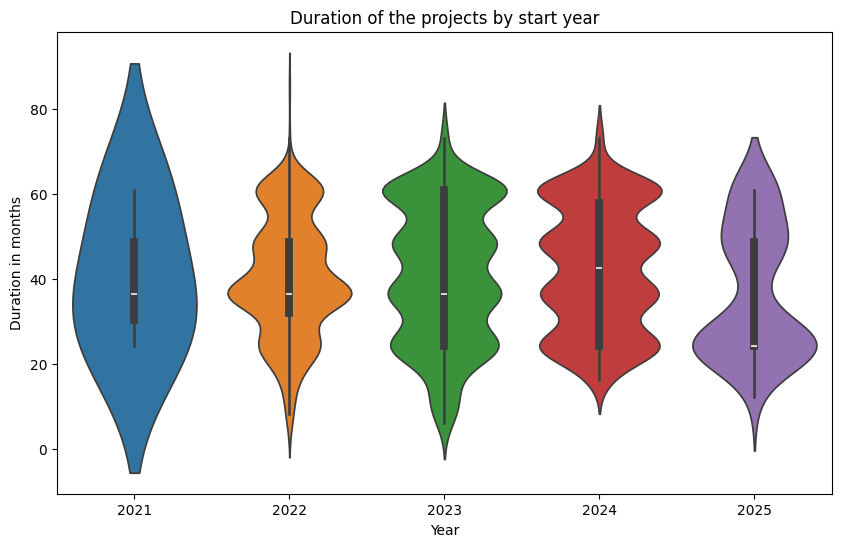

The number of projects ending each year is:
In 2021 there are 3 projects with an average duration: 40.0 months and a std of 15.0 months
In 2022 there are 483 projects with an average duration: 40.0 months and a std of 13.0 months
In 2023 there are 801 projects with an average duration: 40.0 months and a std of 15.0 months
In 2024 there are 691 projects with an average duration: 42.0 months and a std of 14.0 months
In 2025 there are 87 projects with an average duration: 36.0 months and a std of 15.0 months


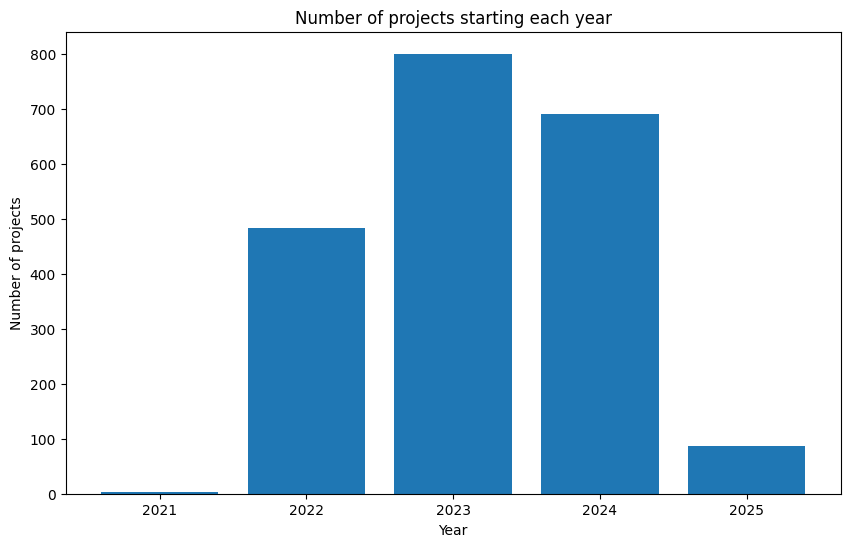

The number of projects ending each year is:
In 2022 there are 2 projects with an average duration: 6.0 months and a std of 0.0 months
In 2023 there are 28 projects with an average duration: 13.0 months and a std of 5.0 months
In 2024 there are 171 projects with an average duration: 20.0 months and a std of 6.0 months
In 2025 there are 416 projects with an average duration: 30.0 months and a std of 6.0 months
In 2026 there are 525 projects with an average duration: 36.0 months and a std of 9.0 months
In 2027 there are 459 projects with an average duration: 47.0 months and a std of 11.0 months
In 2028 there are 315 projects with an average duration: 56.0 months and a std of 6.0 months
In 2029 there are 138 projects with an average duration: 61.0 months and a std of 5.0 months
In 2030 there are 11 projects with an average duration: 67.0 months and a std of 6.0 months


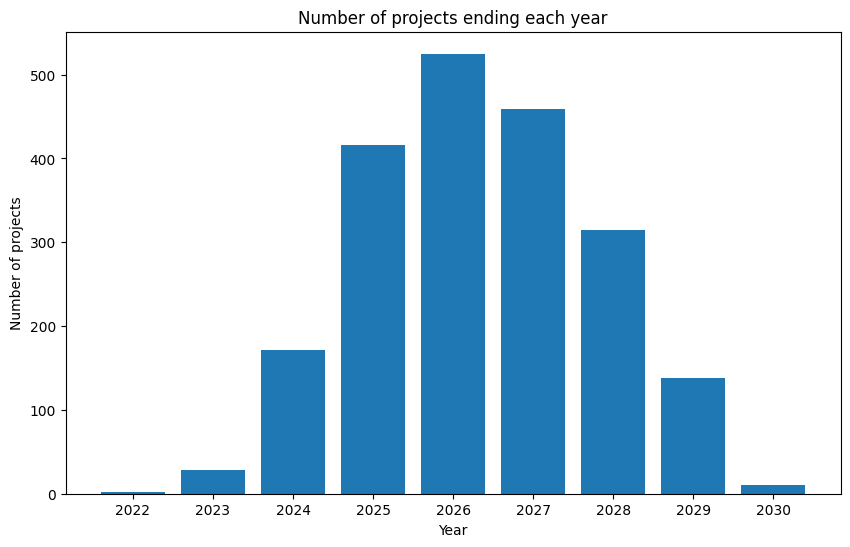

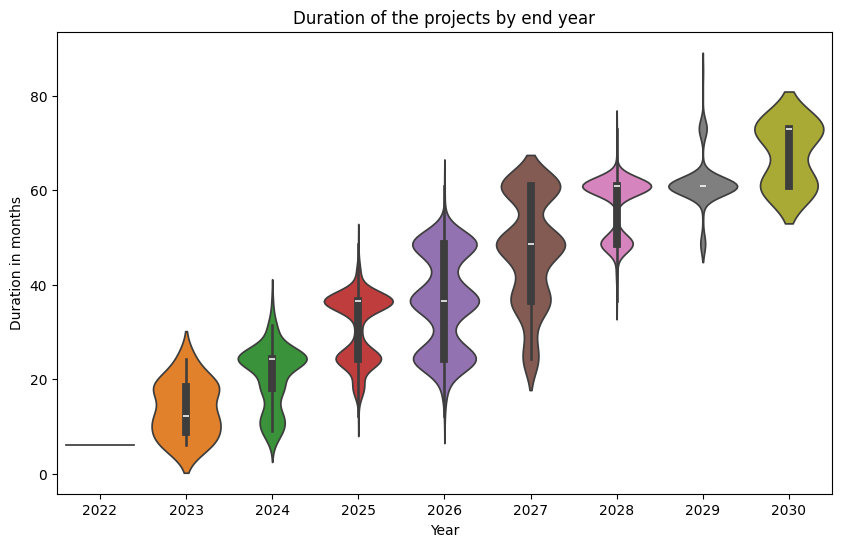

There are 8 clusters.
The number of projects in each cluster is:
0 years: 42
1 years: 274
2 years: 388
3 years: 453
4 years: 420
5 years: 467
6 years: 20
7 years: 1


Text(0, 0.5, 'Number of projects')

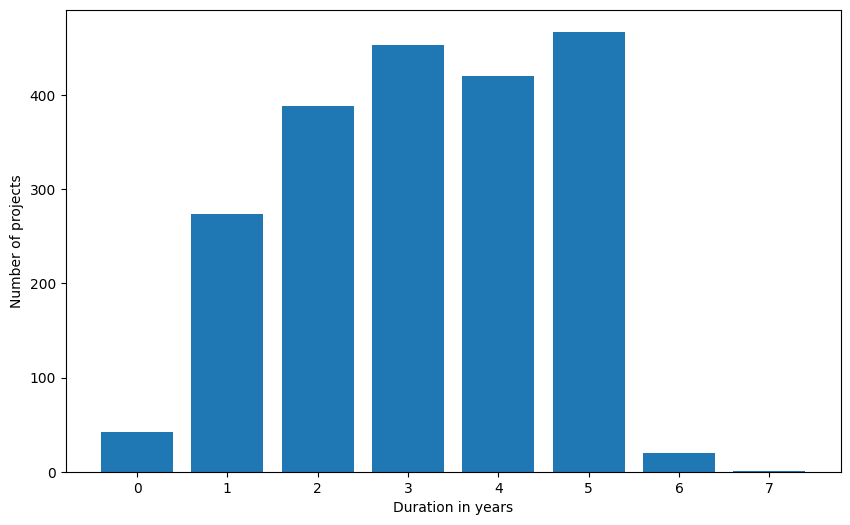

In [32]:
# Time stats (1-4)

# Split budgets in clusters of Xk euros
def chunk_values(budgets, bucket_size,measure="M"):
    budget_clusters = {
        int(non_zero_budgets // bucket_size): 0 for non_zero_budgets in budgets
    }
    for non_zero_budgets in budgets:
        budget_clusters[int(non_zero_budgets // bucket_size)] += 1

    print(f"There are {len(budget_clusters)} clusters.")
    print("The number of projects in each cluster is:")
    for cluster in sorted(budget_clusters.keys()):
        print(f"{cluster}{measure}: {budget_clusters[cluster]}")

    return budget_clusters

# Date related stats
start_dates = [project["startDate"] for project in ai_projects]
end_dates = [project["endDate"] for project in ai_projects]

start_dates = [dt.strptime(date, "%Y-%m-%d") for date in start_dates]
end_dates = [dt.strptime(date, "%Y-%m-%d") for date in end_dates]

durations = [end - start for start, end in zip(start_dates, end_dates)]



average_duration = sum(durations, datetime.timedelta()) / len(durations)
max_duration = max(durations)
min_duration = min(durations)
std_duration = np.std([d.days for d in durations])
print(f"The average duration of the projects is {average_duration.days//30} months with a standard deviation of {std_duration//30} months")
print(f"The minimum duration is {min_duration.days//30} months and the maximum is {max_duration.days//30} months")

duration_by_year_start = {date.year: [] for date in start_dates}
duration_by_year_end = {date.year: [] for date in end_dates}

for start, end, duration in zip(start_dates, end_dates, durations):
    duration_by_year_start[start.year].append(duration.days)
    duration_by_year_end[end.year].append(duration.days)

# Estimate the number of project starting each year
projects_by_year = {date.year: 0 for date in start_dates}
for date in start_dates:
    projects_by_year[date.year] += 1


# PLOTS
# violin plot of the duration of the projects
# X axis is the start year, Y axis is the duration in months

years = sorted(list(duration_by_year_start.keys()))
data = [duration_by_year_start[year] for year in years]
data = [np.array(d) / 30 for d in data]
plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
plt.xticks(range(len(years)), years)
plt.xlabel("Year")
plt.ylabel("Duration in months")
plt.title("Duration of the projects by start year")
plt.show()

# print for each year the average duration of the projects and the std
print("The number of projects ending each year is:")
for year in sorted(duration_by_year_start.keys()):
    print(f"In {year} there are {len(duration_by_year_start[year])} projects with an average duration: {np.mean(duration_by_year_start[year])//30} months and a std of {np.std(duration_by_year_start[year])//30} months")

# plot a bar plot where the X axis is the duration in years and the Y axis is the number of projects
plt.figure(figsize=(10, 6))
plt.bar(range(len(data)), [len(d) for d in data])
plt.xticks(range(len(data)), years)
plt.xlabel("Year")
plt.ylabel("Number of projects")
plt.title("Number of projects starting each year")
plt.show()


# Same plot but for the end year
years = sorted(list(duration_by_year_end.keys()))
data = [duration_by_year_end[year] for year in years]
data = [np.array(d) / 30 for d in data]

# print the number of projects ending each year
print("The number of projects ending each year is:")
for year in sorted(duration_by_year_end.keys()):
    # also print the average duration and std
    print(f"In {year} there are {len(duration_by_year_end[year])} projects with an average duration: {np.mean(duration_by_year_end[year])//30} months and a std of {np.std(duration_by_year_end[year])//30} months")

# plot a bar plot where the X axis is the duration in years and the Y axis is the number of projects
plt.figure(figsize=(10, 6))
plt.bar(range(len(data)), [len(d) for d in data])
plt.xticks(range(len(data)), years)
plt.xlabel("Year")
plt.ylabel("Number of projects")
plt.title("Number of projects ending each year")
plt.show()



plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
plt.xticks(range(len(years)), years)
plt.xlabel("Year")
plt.ylabel("Duration in months")
plt.title("Duration of the projects by end year")
plt.show()

duration_chunks=chunk_values([d.days for d in durations], 365, " years")
# plot
plt.figure(figsize=(10, 6))
plt.bar(duration_chunks.keys(), duration_chunks.values())
plt.xlabel("Duration in years")
plt.ylabel("Number of projects")


There are 0 projects with a budget of 0
The average non zero budget of the projects is 3161809.57 with a standard deviation of 3400367.33 (107.5% of the average)
The minimum budget is 75000.00 and the maximum budget is 46225689.31
There are 24 clusters.
The number of projects in each cluster is:
0M: 554
1M: 383
2M: 392
3M: 157
4M: 166
5M: 125
6M: 67
7M: 59
8M: 54
9M: 33
10M: 18
11M: 16
12M: 4
13M: 10
14M: 8
15M: 2
16M: 1
17M: 6
19M: 2
22M: 2
23M: 1
24M: 2
25M: 2
46M: 1


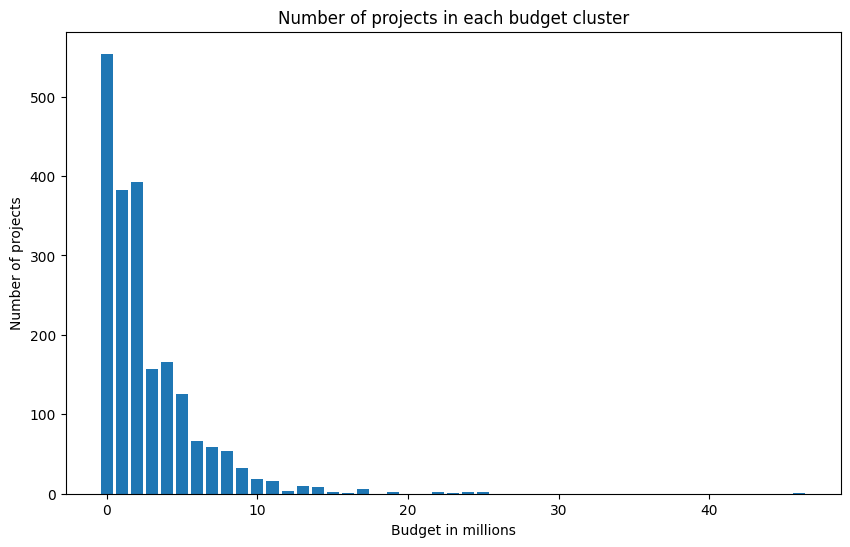

90% of the projects have a budget below 7M


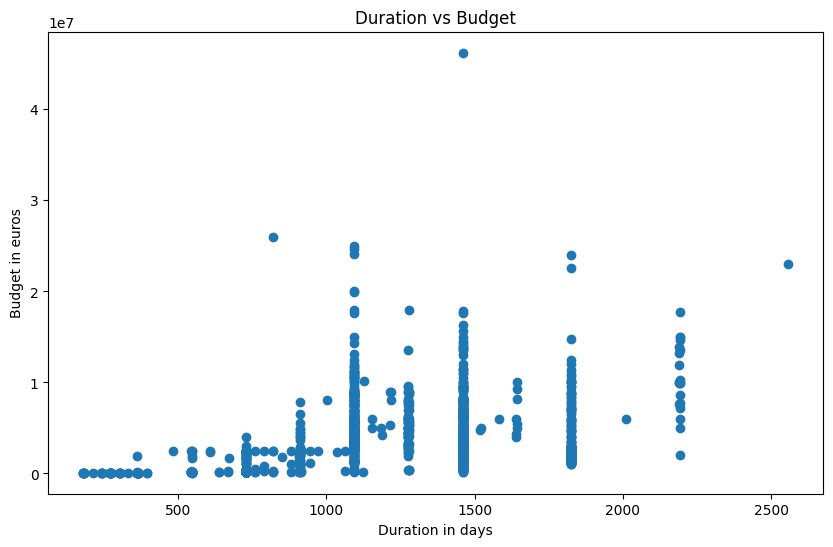

The correlation between duration and budget is 0.31 with a pvalue of 0.0000000


In [33]:
# Budget related stats (5)

# Get the budget of the projects
budgets = [project["ecMaxContribution"] for project in ai_projects]
budgets = [float(budget) for budget in budgets]

zero_budgets = sum([budget == 0 for budget in budgets])
print(f"There are {zero_budgets} projects with a budget of 0")

non_zero_budgets = [budget for budget in budgets if budget != 0]

average_budget = sum(non_zero_budgets) / len(non_zero_budgets)
std_budget = np.std(non_zero_budgets)
min_budget = min(non_zero_budgets)
max_budget = max(non_zero_budgets)
print(
    f"The average non zero budget of the projects is {average_budget:.2f} with a standard deviation of {std_budget:.2f} ({std_budget/average_budget:.1%} of the average)"
)
print(
    f"The minimum budget is {min_budget:.2f} and the maximum budget is {max_budget:.2f}"
)





budget_clusters = chunk_values(non_zero_budgets, 1e6)
# Plot the number of projects in each budget cluster
plt.figure(figsize=(10, 6))
plt.bar(budget_clusters.keys(), budget_clusters.values())
plt.xlabel("Budget in millions")
plt.ylabel("Number of projects")
plt.title("Number of projects in each budget cluster")
plt.show()

# Get the limit below which 90% of the projects are
cumulative_budget = 0
for cluster in sorted(budget_clusters.keys()):
    cumulative_budget += budget_clusters[cluster]
    if cumulative_budget / len(budgets) > 0.9:
        print(f"90% of the projects have a budget below {cluster}M")
        break


# check if the budget correlates to the duration
budgets = np.array(budgets)
durations_days = np.array(durations)

# remove durations with zero budget
duration_budget = [
    (duration.days, budget)
    for duration, budget in zip(durations_days, budgets)
    if budget
]


duration_budget = list(zip(*duration_budget))

# plot the duration vs budget
plt.figure(figsize=(10, 6))
plt.scatter(duration_budget[0], duration_budget[1])
plt.xlabel("Duration in days")
plt.ylabel("Budget in euros")
plt.title("Duration vs Budget")
plt.show()

# estimate the correlation and pvalue
correlation, pvalue = pearsonr(duration_budget[0], duration_budget[1])
print(
    f"The correlation between duration and budget is {correlation:.2f} with a pvalue of {pvalue:.7f}"
)

In [34]:
# Stats on budget and time

# Estimate the budget per month
budget_per_month = budgets / [duration.days / 30 for duration in durations]
budget_per_month = [budget for budget in budget_per_month if budget]

average_budget_per_month = sum(budget_per_month) / len(budget_per_month)
std_budget_per_month = np.std(budget_per_month)
min_budget_per_month = min(budget_per_month)
max_budget_per_month = max(budget_per_month)
print(
    f"The average budget per month of the projects is {average_budget_per_month:.2f} with a standard deviation of {std_budget_per_month:.2f} ({std_budget_per_month/average_budget_per_month:.1%} of the average)"
)

print(
    f"The minimum budget per month is {min_budget_per_month:.2f} and the maximum budget per month is {max_budget_per_month:.2f}"
)

# Find correlation between budget  and duration
correlation, pvalue = pearsonr(budgets, [duration.days / 30 for duration in durations])
print(
    f"The correlation between budget per month and duration is {correlation:.2f} with a pvalue of {pvalue:.7f}"
)

# Find correlation between budget and start year
correlation, pvalue = pearsonr(budgets, [date.year for date in start_dates])
print(
    f"The correlation between budget and start year is {correlation:.2f} with a pvalue of {pvalue:.7f}"
)

# Find correlation between budget and end year
correlation, pvalue = pearsonr(budgets, [date.year for date in end_dates])
print(
    f"The correlation between budget and end year is {correlation:.2f} with a pvalue of {pvalue:.7f}"
)

The average budget per month of the projects is 73578.25 with a standard deviation of 79428.91 (108.0% of the average)
The minimum budget per month is 2835.62 and the maximum budget per month is 950627.63
The correlation between budget per month and duration is 0.31 with a pvalue of 0.0000000
The correlation between budget and start year is -0.11 with a pvalue of 0.0000002
The correlation between budget and end year is 0.15 with a pvalue of 0.0000000


In [35]:
# Stats on the most common words (6)

# Get all the words in the objectives and titles
objectives_words = [project["objective"].lower() for project in ai_projects]
titles_words = [project["title"].lower() for project in ai_projects]


def clean_text(text, remove_stopwords=True, remove_verbs=True, lemmatize=True):
    # remove stopwords

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text = " ".join([word for word in text.split(" ") if word not in stop_words])

    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # remove punctuation
    tokens = [word for word in tokens if word.isalnum()]

    # remove verbs
    if remove_verbs:
        tagged = nltk.pos_tag(tokens)
        text = " ".join(
            [
                word
                for word, tag in tagged
                if tag not in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
            ]
        )

    if not lemmatize:
        return text
    
    # apply lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

    return text

remove_verbs=False

objectives_words = [clean_text(objective,remove_verbs=remove_verbs) for objective in objectives_words]
titles_words = [clean_text(title,remove_verbs=remove_verbs) for title in titles_words]
common_words = [
    " ".join([objective, title])
    for objective, title in zip(objectives_words, titles_words)
]

The most common words in objectives are:
data: 3447
ai: 2366
project: 2251
The most common words in titles are:
ai: 234
learning: 200
data: 174
The most common words in objectives and titles are:
data: 3621
ai: 2600
project: 2259
learning: 1968
based: 1968
new: 1753
research: 1685
system: 1616
technology: 1551
model: 1526
approach: 1211
machine: 1159
development: 1148
use: 1103
develop: 1101
network: 1077
high: 1063
aim: 1004
the: 1002
human: 980


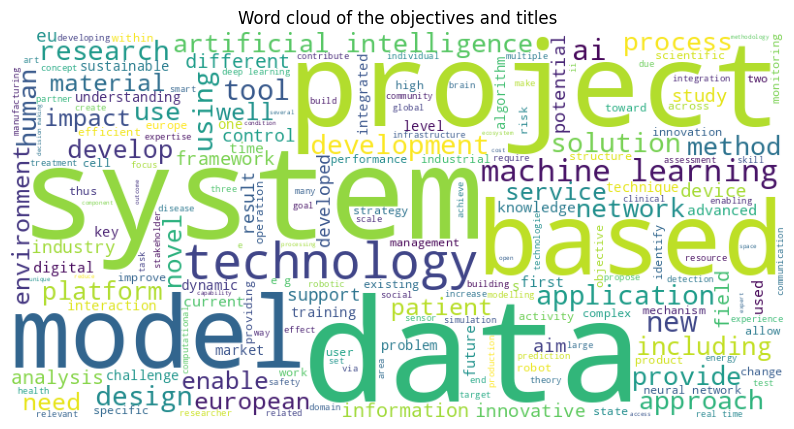

In [36]:
# Create a word cloud of the most common words
def create_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(words)
    )
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()



# print top 10 words

def topx_words(word_list, name="",top=3,):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(word_list)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    print(f"The most common words in {name} are:")
    for word, freq in words_freq[:top]:
        print(f"{word}: {freq}")

topx_words(objectives_words, "objectives")
topx_words(titles_words, "titles")
topx_words(common_words, "objectives and titles", top=20)


#create_word_cloud(objectives_words, "Word cloud of the objectives")
#create_word_cloud(titles_words, "Word cloud of the titles")
create_word_cloud(common_words, "Word cloud of the objectives and titles")



R2: 0.7924768900651642


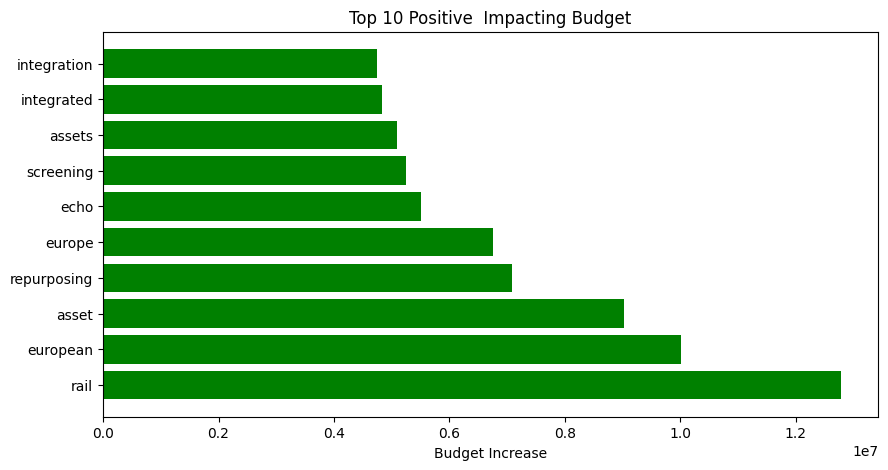

Top 10 Positive Words Impacting Budget
rail           1.279043e+07
european       1.001977e+07
asset          9.033869e+06
repurposing    7.084599e+06
europe         6.751928e+06
echo           5.506343e+06
screening      5.257433e+06
assets         5.097565e+06
integrated     4.826780e+06
integration    4.752037e+06
dtype: float64


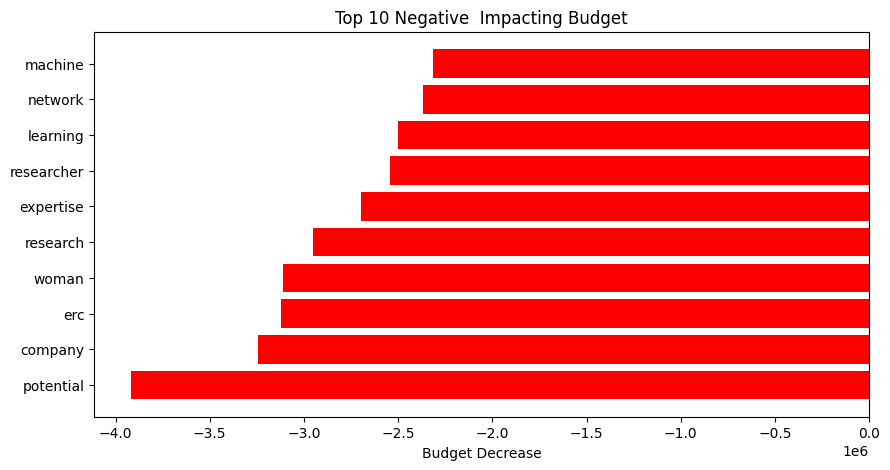

Top 10 Negative  Impacting Budget
potential    -3.917755e+06
company      -3.243554e+06
erc          -3.122091e+06
woman        -3.108906e+06
research     -2.949384e+06
expertise    -2.694523e+06
researcher   -2.540614e+06
learning     -2.500763e+06
network      -2.366243e+06
machine      -2.313518e+06
dtype: float64


In [42]:
# Correlated words with the budget

# create dataframes with the words and the budget
#df = pd.DataFrame({"words": objectives_words, "budget": budgets})
#df = pd.DataFrame({"words": titles_words, "budget": budgets})
df = pd.DataFrame({"words": common_words, "budget": budgets})


def words_coefficient(words,budget):
    # Convert the descriptions into a bag of words (unigrams in this case)
    vectorizer = TfidfVectorizer(stop_words="english", min_df=2)
    X = vectorizer.fit_transform(words)

    # Create a DataFrame for word counts
    word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Add the budget information to the DataFrame
    word_counts["budget"] = budget


    # Create features (word counts) and target (budget)
    X = word_counts.drop(columns="budget")
    y = word_counts["budget"]


    # Fit the regression model
    model = Ridge()
    model.fit(X, y)

    # Evaluate the model
    print(f"R2: {model.score(X, y)}")



    # Get coefficients of the model (impact of each word on the budget)
    coef = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)

    return coef

def plot_print_coef(coef, title=""):
    # Sort coefficients
    top_positive = coef.sort_values(ascending=False).head(10)

    # Plot Positive Words
    plt.figure(figsize=(10, 5))
    plt.barh(top_positive.index, top_positive.values, color="green")
    plt.xlabel("Budget Increase")
    plt.title(f"Top 10 Positive {title} Impacting Budget")
    plt.show()

    print("Top 10 Positive Words Impacting Budget")
    print(top_positive)

    #Plot Negative Words
    top_negative = coef.sort_values(ascending=True).head(10)
    plt.figure(figsize=(10, 5))
    plt.barh(top_negative.index, top_negative.values, color="red")
    plt.xlabel("Budget Decrease")
    plt.title(f"Top 10 Negative {title} Impacting Budget")
    plt.show()

    print(f"Top 10 Negative {title} Impacting Budget")
    print(top_negative)


coef=words_coefficient(df['words'],df['budget'])
plot_print_coef(coef)


There are 62 projects in the EIE subcall and 66 projects in the WIDERA subcall
There are 491 topics in the dataset.
The top 10 topics are:
HORIZON-MSCA-2023-PF-01-01: 141
HORIZON-MSCA-2022-PF-01-01: 112
HORIZON-MSCA-2021-PF-01-01: 104
ERC-2021-STG: 61
ERC-2023-STG: 60
ERC-2022-STG: 53
ERC-2022-COG: 52
ERC-2023-COG: 47
HORIZON-EIE-2022-SCALEUP-02-02: 46
ERC-2021-COG: 39


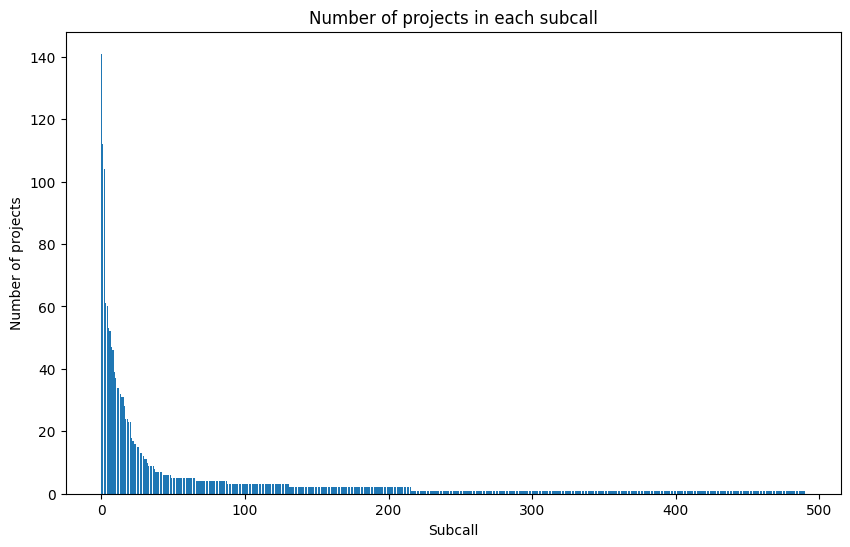

90% of the projects are in the top 284 topics


In [50]:
# analyze the subCall field
topics = [project["topics"] for project in ai_projects]

# Count the number of projects in each subcall
subcalls_count = {subcall: 0 for subcall in topics}
for subcall in topics:
    subcalls_count[subcall] += 1

# sort by number of projects
subcalls_count = {k: v for k, v in sorted(subcalls_count.items(), key=lambda item: item[1], reverse=True)}

# print total number of topics
print(f"There are {len(subcalls_count)} topics in the dataset.")
# print top 10
print("The top 10 topics are:")
for subcall in list(subcalls_count.keys())[:10]:
    print(f"{subcall}: {subcalls_count[subcall]}")

#plot the number of projects in each subcall with no labels
plt.figure(figsize=(10, 6))
plt.bar(range(len(subcalls_count)), subcalls_count.values())
plt.xlabel("Subcall")
plt.ylabel("Number of projects")
plt.title("Number of projects in each subcall")
plt.show()

# get percentiles of the topics
cumulative_subcalls = 0
for idx,subcall in enumerate(subcalls_count):
    cumulative_subcalls += subcalls_count[subcall]
    if cumulative_subcalls / len(topics) > 0.9:
        print(f"90% of the projects are in the top {idx} topics")
        break


R2: 0.7112082040280732


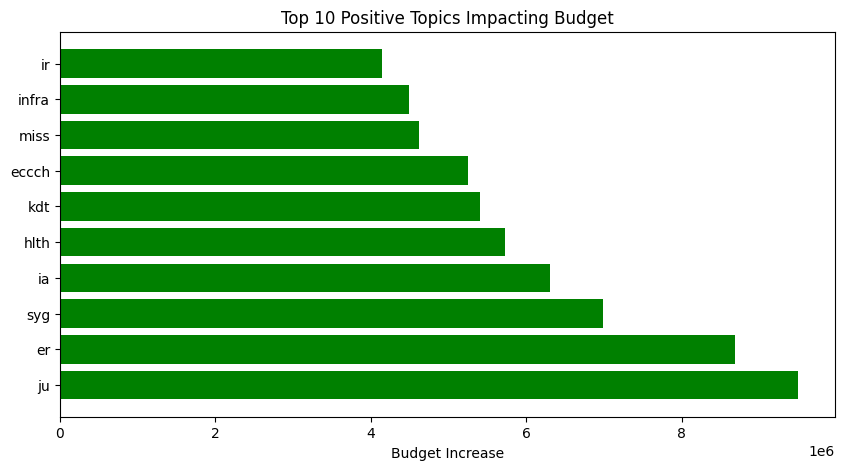

Top 10 Positive Words Impacting Budget
ju       9.497061e+06
er       8.684565e+06
syg      6.994378e+06
ia       6.305661e+06
hlth     5.733113e+06
kdt      5.401856e+06
eccch    5.256403e+06
miss     4.615367e+06
infra    4.489860e+06
ir       4.143250e+06
dtype: float64


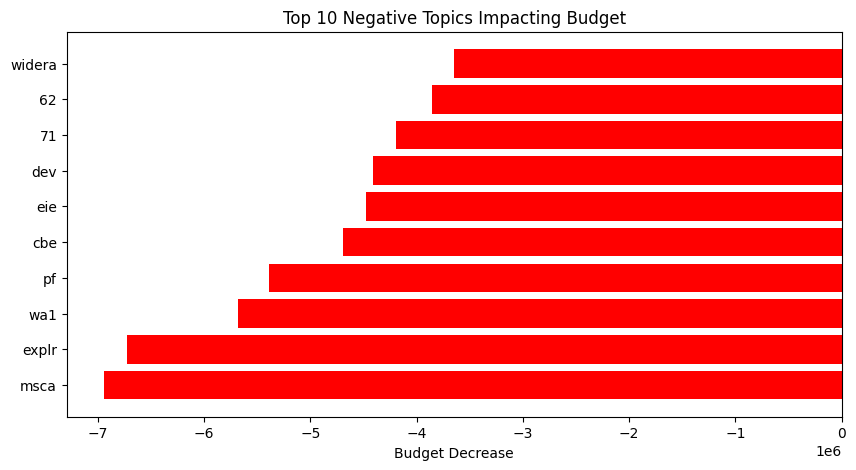

Top 10 Negative Topics Impacting Budget
msca     -6.944503e+06
explr    -6.724138e+06
wa1      -5.682473e+06
pf       -5.384034e+06
cbe      -4.694922e+06
eie      -4.479784e+06
dev      -4.408264e+06
71       -4.193075e+06
62       -3.859231e+06
widera   -3.646123e+06
dtype: float64


In [45]:
# Correlation between topics and budget
# create dataframes with the topics and the budget
df = pd.DataFrame({"topics": topics, "budget": budgets})

coef=words_coefficient(topics,budgets)
plot_print_coef(coef, title="Topics")



Now it's time to check what we're here for. The similarities between proposals

In [52]:
# Get all the words in the objectives and titles
objectives_words = [project["objective"].lower() for project in ai_projects]
titles_words = [project["title"].lower() for project in ai_projects]


objectives_words = [clean_text(objective,remove_stopwords=False, remove_verbs=False, lemmatize=False) for objective in objectives_words]
titles_words = [clean_text(title,remove_stopwords=False, remove_verbs=False, lemmatize=False) for title in titles_words]
common_words = [
    " ".join([objective, title])
    for objective, title in zip(objectives_words, titles_words)
]

chosen = common_words

model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Encode the project descriptions into embeddings
embeddings = model.encode(chosen)

# Compute cosine similarity between the project embeddings
similarity_matrix = cosine_similarity(embeddings)

# Display the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=chosen, columns=chosen)




/Users/nbrandizzi/Library/Caches/pypoetry/virtualenvs/pipeline-commons-ZcR9KJaW-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


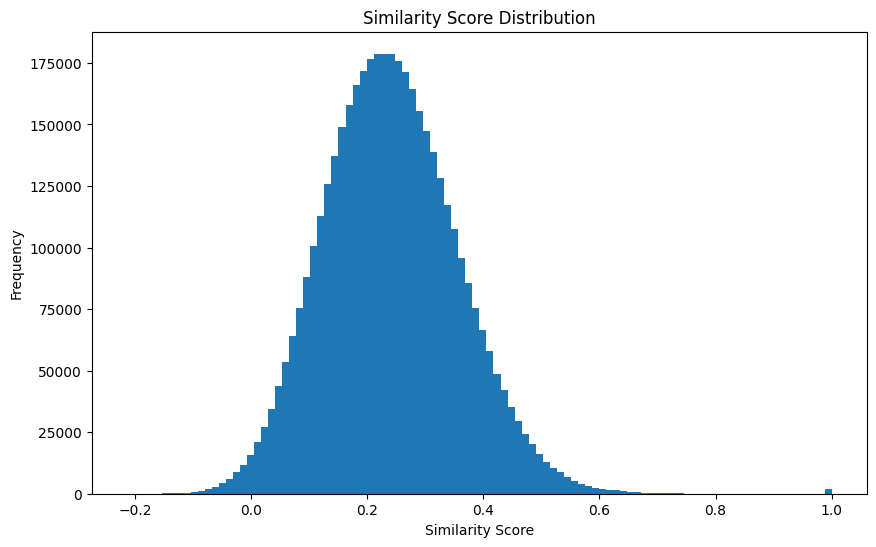

Similarity Scores mean: 0.24
Similarity Scores std: 0.12
Number of pairs with similarity scores above 0.95: 2.0
Number of pairs with similarity scores above 0.9: 2.0
Number of pairs with similarity scores above 0.85: 9.0
Number of pairs with similarity scores above 0.8: 37.0
Number of pairs with similarity scores above 0.75: 142.0
Number of pairs with similarity scores above 0.7: 478.0
Number of pairs with similarity scores above 0.6: 4647.0
Number of pairs with similarity scores above 0.5: 33350.0


In [55]:
# Plot the similarity scores as a distribution with bars
plt.figure(figsize=(10, 6))
plt.hist(similarity_matrix.flatten(), bins=100)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Similarity Score Distribution")
plt.show()

# Print mean and standard deviation of the similarity scores
print(f"Similarity Scores mean: {np.mean(similarity_matrix):.2f}")
print(f"Similarity Scores std: {np.std(similarity_matrix):.2f}")

# Find how many scores are above 
thresholds = [0.95,0.9, 0.85,0.8, 0.75,0.7, 0.6,0.5]
for threshold in thresholds:
    above_threshold = np.sum(similarity_matrix > threshold) - len(similarity_matrix)
    above_threshold = above_threshold /2
    print(f"Number of pairs with similarity scores above {threshold}: {above_threshold}")


In [124]:
similar_projects = []
threshold = 0.70
# Loop over the similarity matrix
for i, project in enumerate(ai_projects):
    for j in range(len(chosen)):
        if (
            i != j and threshold < similarity_matrix[i, j] < 1.0
        ):  # Above threshold but not exactly 1 (identical)
            similar_projects.append(
                (
                    project,
                    ai_projects[j],
                    similarity_matrix[i, j],
                )
            )

# remove duplicates
for i, proj1 in enumerate(similar_projects):
    for j, proj2 in enumerate(similar_projects):
        if i != j and proj1[0] == proj2[1] and proj1[1] == proj2[0]:
            similar_projects.pop(j)
            break

# Sort the similar projects by similarity score
similar_projects = sorted(similar_projects, key=lambda x: x[2], reverse=True)
# Print the similar projects
to_save = "The projects with similarity above 0.9 but not identical are:\n"
for proj1, proj2, sim in similar_projects:
    to_save += f"Similarity score of {sim:.3f}:\n\
        \t1.{proj1['acronym']}: {proj1['title']}\n\
        \t1.{proj2['acronym']}: {proj2['title']}\n\n"

with open(f"similar_projects_sim{threshold*100}.txt", "w") as f:
    f.write(to_save)

print(f"The projects with similarity above {int(threshold*100)}% but are {len(similar_projects)}")

The projects with similarity above 70% but are 478


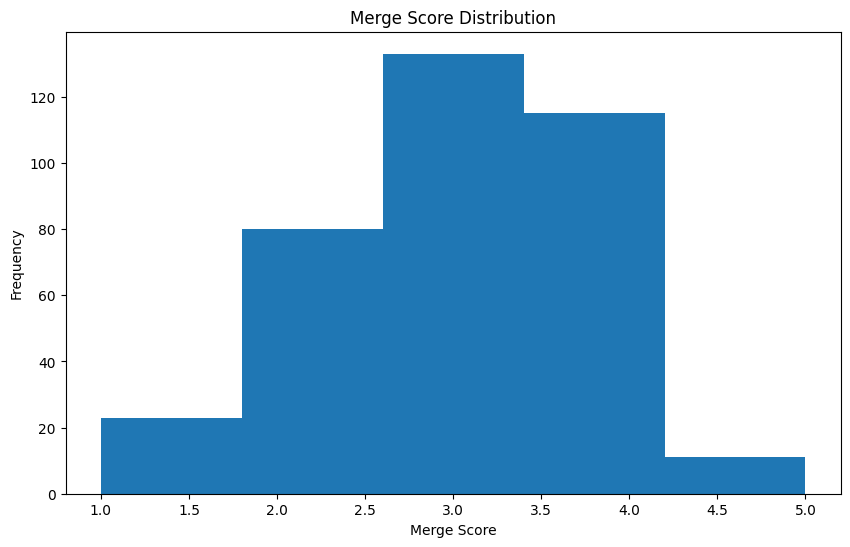

In [56]:
# Now time to go big. Let's use an llm with all the similar pairs of projects to score the ones that should be merged



PROMT_TEMPLATE = """
You are tasked with evaluating the similarity between two research projects and determining whether they should be merged. The projects will be evaluated on five criteria using an additive 5-point scoring system based on how well they satisfy each criterion:

- Add 1 point if the projects share some minor objectives or methods but differ significantly in most areas.
- Add another point if the projects have some overlapping goals, methodologies, or innovations, but also include distinct elements that make them different enough to proceed separately.
- Award a third point if the projects share key similarities in scope, methodology, and innovation but retain enough distinctions to benefit from remaining independent. Resource efficiency may not be substantial, and merging may only yield moderate benefits.
- Grant a fourth point if the projects align closely in scope, methodology, and innovation, and combining them would improve resource efficiency. Merging would likely benefit the overall research output, but they could still function separately with some loss of efficiency.
- Bestow a fifth point if the projects are nearly identical in scope, methodology, and innovation. Merging them would significantly optimize resource use, and keeping them separate would be inefficient.

After scoring each criterion, summarize your analysis in a brief justification, considering the potential benefits of merging and any reasons against merging. Conclude with a structured JSON output containing the parameters "score" and "justification".

The projects:
```PROJ1```

```PROJ2```


"""

client = OpenAI(
    api_key="""YOUR KEY""",
)


def evaluate_projects(project_1, project_2):
    prompt = PROMT_TEMPLATE

    project_1 = f"{project_1['acronym']}: {project_1['title']}.\n{project_1['objective']}"
    project_2 = f"{project_2['acronym']}: {project_2['title']}.\n{project_2['objective']}"
   
    prompt = prompt.replace("PROJ1", project_1)
    prompt = prompt.replace("PROJ2", project_2)

    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o",
     response_format={ "type": "json_object" }
    )

    return response.choices[0].message.content

def parse_merge_score(response):
    #Try to parse with json format
    try:
        response = json.loads(response)
        if "score" in response and "justification" in response:
            return response['score'], response['justification']
    except Exception as e:
        print(e)
    
    return None, None


#sim_projs = similar_projects[-5:-1]

def generate_scores():
    chatgpt_scores = []
    errors=[]

    for proj1, proj2, sim in tqdm(similar_projects):



        evaluation = evaluate_projects(proj1, proj2)
        #print(evaluation)
        merge_score, justification = parse_merge_score(evaluation)


        
        if merge_score is None:
            errors.append((proj1, proj2))
            print(f"Error with {proj1['acronym']} and {proj2['acronym']}")
            print(f"Total errors: {len(errors)}")
            continue


        eval={"proj1": proj1, "proj2": proj2, "justification": justification, "merge_score": merge_score, "similarity": sim}
        chatgpt_scores.append(eval)
        #print(evaluation)


    # Save the evaluations
    with open("chatgpt_scores.json", "w") as f:
        json.dump(chatgpt_scores, f, indent=4)
    
    # Save the errors
    with open("chatgpt_errors.json", "w") as f:
        json.dump(errors, f, indent=4)


def load_scores():
    with open("chatgpt_scores.json") as f:
        chatgpt_scores = json.load(f)
    return chatgpt_scores

# You can either generate the scores or load them from the file
#generate_scores()
chatgpt_scores = load_scores()

# Plot the distribution of the scores
scores = [score["merge_score"] for score in chatgpt_scores]
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=5)
plt.xlabel("Merge Score")
plt.ylabel("Frequency")
plt.title("Merge Score Distribution")
plt.show()


In [126]:
# Now we want to check the correlation between the similarity and the merge score
similarity = [eval["similarity"] for eval in chatgpt_scores]
merge_scores = [eval["merge_score"] for eval in chatgpt_scores]

correlation, pvalue = pearsonr(similarity, merge_scores)
print(
    f"The correlation between similarity and merge score is {correlation:.2f} with a pvalue of {pvalue:.7f}"
)

The correlation between similarity and merge score is 0.14 with a pvalue of 0.0088993


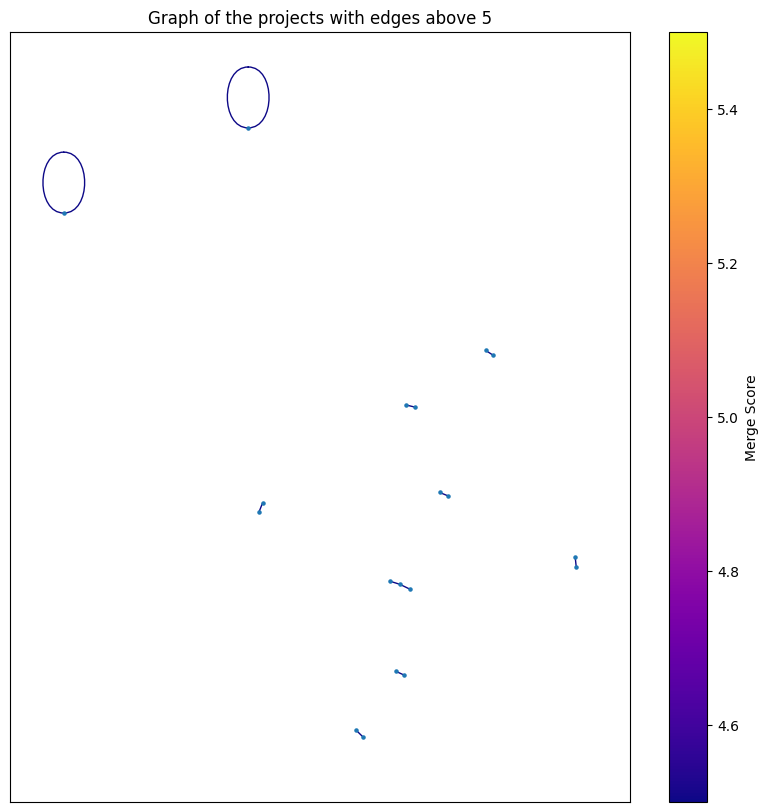

There are 10 components in the graph.
Component 3: {'ENLIGHTEN', 'ENLIGHTEN-ED'}
Component 4: {'OPTGEN', 'GENERALIZATION'}
Component 5: {'6G-INTENSE', '6G-BRICKS', 'SUNRISE-6G'}
Component 6: {'TIRAMISU', 'EdgeAI'}
Component 7: {'BeCoM', 'E-CONTRAIL'}
Component 8: {'REAL-RL', 'BAYES-RL'}
Component 9: {'COMMUTE', 'NEUROCOV'}
Component 10: {'DL-ElastoMark', 'DL-MechanoPredictor'}
There are 8 connected components and 2 isolated nodes.
The mean size of the connected components is 2.12 and the maximum size is 3


In [124]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors

EDGE_THRESHOLD = 5
G = nx.Graph()

# Add edges with weight
for eval in chatgpt_scores:
    if eval["merge_score"] >= EDGE_THRESHOLD:
        G.add_edge(eval["proj1"]["acronym"], eval["proj2"]["acronym"], weight=eval["merge_score"])

# Set up the graph layout
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G,k=0.1,iterations=50)

# Get edge weights and normalize them for coloring
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
norm = plt.Normalize(min(weights), max(weights))
cmap = plt.cm.plasma  # You can change the colormap here

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=5)

# Draw the edges with colors based on the weight (merge_score)
nx.draw_networkx_edges(
    G, pos, edgelist=edges, width=1,
    edge_color=weights, edge_cmap=cmap, edge_vmin=min(weights), edge_vmax=max(weights),
)

# Optionally, draw labels for nodes
#nx.draw_networkx_labels(G, pos, font_size=10)

# Create a new axis for the colorbar
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(weights)
cbar = plt.colorbar(sm, ax=ax, label="Merge Score")

# Add a title and display the graph
plt.title(f"Graph of the projects with edges above {EDGE_THRESHOLD}")
plt.show()

# Now we want to find the connected components of the graph
components = list(nx.connected_components(G))
print(f"There are {len(components)} components in the graph.")

isolated = 0
connected = 0
connected_components = []
connection_sizes = []
# Print list of connected components
for i, component in enumerate(components):
    if len(component) > 1:
        print(f"Component {i+1}: {component}")
        connected += 1
        connected_components.append(component)
        connection_sizes.append(len(component))
    else:
        isolated += 1

print(f"There are {connected} connected components and {isolated} isolated nodes.")
mean_size = sum(connection_sizes) / len(connection_sizes)
max_size = max(connection_sizes)
print(f"The mean size of the connected components is {mean_size:.2f} and the maximum size is {max_size}")


There are 3 clusters.
The number of projects in each cluster is:
0M: 4
1M: 2
3M: 2
There are 5 clusters.
The number of projects in each cluster is:
0 months: 4
3 months: 1
5 months: 1
6 months: 1
9 months: 1
There are 8(100.0%) connected projects with a duration of less than 12 months


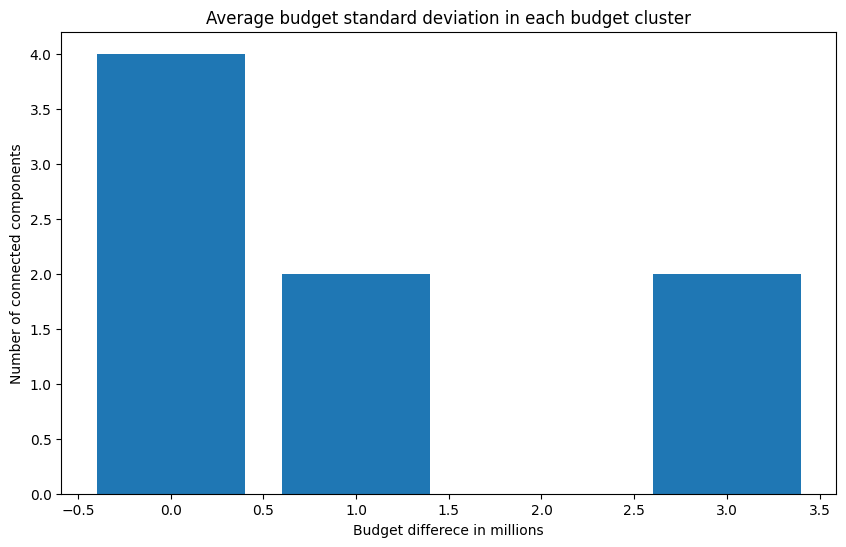

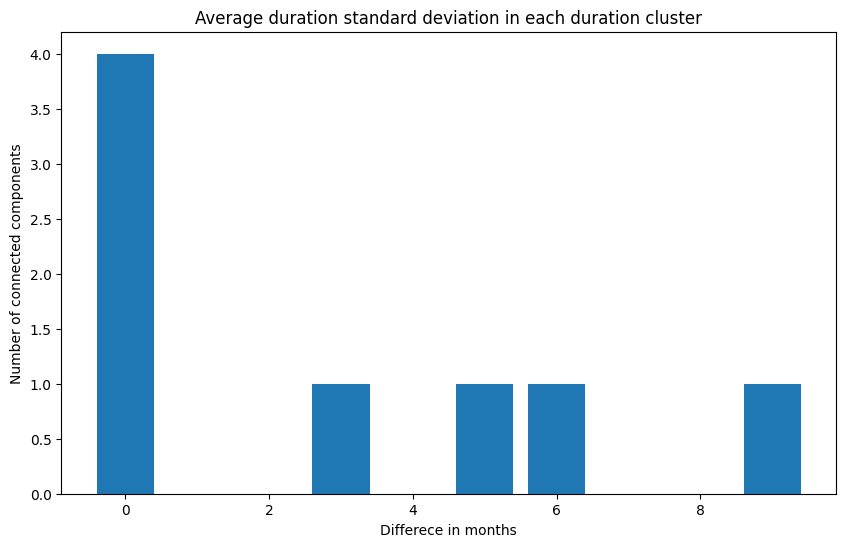

In [125]:
# Create a list of connected components with the projects

connected_components_projects = []
for components in connected_components:
    projects = []
    for component in components:
        project = [project for project in ai_projects if project["acronym"] == component]
        projects.extend(project)
    connected_components_projects.append(projects)


budget_std=[]
duration_std=[]
all_budgets=[]
# Perform an analysis on budget and duration of the connected components
for i, component in enumerate(connected_components_projects):
    #print(f"Connected component {i+1} with {len(component)} projects")
    budgets = [project["ecMaxContribution"] for project in component]
    budgets = [float(budget) for budget in budgets]
    all_budgets.append(budgets)

    zero_budgets = sum([budget == 0 for budget in budgets])

    non_zero_budgets = [budget for budget in budgets if budget != 0]

    if not non_zero_budgets:
        #print("No non zero budgets")
        continue


    average_budget = sum(non_zero_budgets) / len(non_zero_budgets)
    std_budget = np.std(non_zero_budgets)
    min_budget = min(non_zero_budgets)
    max_budget = max(non_zero_budgets)
    # print(
    #     f"The average non zero budget of the projects is {average_budget:.2f} with a standard deviation of {std_budget:.2f} ({std_budget/average_budget:.1%} of the average)"
    # )

    # Same for duration
    start_dates = [project["startDate"] for project in component]
    end_dates = [project["endDate"] for project in component]

    start_dates = [dt.strptime(date, "%Y-%m-%d") for date in start_dates]
    end_dates = [dt.strptime(date, "%Y-%m-%d") for date in end_dates]

    durations = [end - start for start, end in zip(start_dates, end_dates)]

    average_duration = sum(durations, datetime.timedelta()) / len(durations)
    std_duration = np.std([d.days for d in durations])

    durations_days = np.array(durations)

    #print(f"The average duration of the projects is {average_duration.days//30} months with a standard deviation of {std_duration//30} months")
   

    budget_std.append(std_budget)
    duration_std.append(std_duration)


budget_clusters = chunk_values(budget_std, 1e6,"M")
duration_clusters = chunk_values(duration_std, 30," months")

# count the number of projects where duration_clusters is less than 12 months
short_duration = sum([v for k,v in duration_clusters.items() if k<12])
print(f"There are {short_duration}({short_duration/len(duration_std):.1%}) connected projects with a duration of less than 12 months")

# Plot the number of projects in each budget cluster
plt.figure(figsize=(10, 6))
plt.bar(budget_clusters.keys(), budget_clusters.values())
plt.xlabel("Budget differece in millions")
plt.ylabel("Number of connected components")
plt.title("Average budget standard deviation in each budget cluster")
plt.show()


# Plot the standard deviation of the duration with bars

plt.figure(figsize=(10, 6))
plt.bar(duration_clusters.keys(), duration_clusters.values())
plt.xlabel("Differece in months")
plt.ylabel("Number of connected components")
plt.title("Average duration standard deviation in each duration cluster")
plt.show()


In [126]:

total_budget = sum([sum(budget) for budget in all_budgets])

discounted_budgets = 0
for budgets in all_budgets:
    num=len(budgets)
    discount_factor=(num+1)/(2*num)
    discounted_budgets += sum([b*discount_factor for b in budgets]) 

horizon_total_budget = 9.5e10
horizon_total_budget_ai=sum([project["ecMaxContribution"] for project in ai_projects])
print(f"The total budget of the connected components is {total_budget:.2f} and the total discounted budget is {discounted_budgets:.2f} which is {discounted_budgets/total_budget:.1%} of the total budget")
print(f"The total savings are {total_budget-discounted_budgets:.2f} which is {(total_budget-discounted_budgets)/horizon_total_budget:.3%} of the total Horizon budget and {(total_budget-discounted_budgets)/horizon_total_budget_ai:.1%} of the total Horizon budget for AI projects")


The total budget of the connected components is 104943053.95 and the total discounted budget is 76580204.64 which is 73.0% of the total budget
The total savings are 28362849.31 which is 0.030% of the total Horizon budget and 0.4% of the total Horizon budget for AI projects


In [127]:
total_budget = sum([sum(budget) for budget in all_budgets])

discounted_budgets = 0
for budgets in all_budgets:
    
    discounted_budgets += max([b for b in budgets]) 

savings = total_budget-discounted_budgets
horizon_total_budget_ai=sum([project["ecMaxContribution"] for project in ai_projects])
print(f"The total budget of the connected components is {total_budget:.2f} and the total discounted budget is {discounted_budgets:.2f} which is {discounted_budgets/total_budget:.1%} of the total budget")
print(f"The total savings are {savings:.2f} which is {savings/horizon_total_budget:.3%} of the total Horizon budget and {savings/horizon_total_budget_ai:.1%} of the total Horizon budget for AI projects")


The total budget of the connected components is 104943053.95 and the total discounted budget is 59741284.92 which is 56.9% of the total budget
The total savings are 45201769.03 which is 0.048% of the total Horizon budget and 0.7% of the total Horizon budget for AI projects
